Dataset: GunPoint
https://www.timeseriesclassification.com/description.php?Dataset=GunPoint

Goal: Use above time series data set, convert it to image repesentation, use Computer Vision Convolutional neural network to predict is:  "gun" or "no gun (pointing)"

Aproach: represent time series using Markov Transiotion Field and Gramian angular field to represent timeseries as image 

In [2]:
from fastai import *
from fastai.vision import *
from fastai.imports import *

In [5]:
# load train and test data
test_path = Path("GunPoint/GunPoint_TEST.txt")
train_path = Path("GunPoint/GunPoint_TRAIN.txt")
train_path, test_path

(Path('GunPoint/GunPoint_TRAIN.txt'), Path('GunPoint/GunPoint_TEST.txt'))

In [6]:
# Convert  Test (txt to csv)
raw = open(test_path).readlines() 
raw = [map(float, each.strip().split()) for each in raw] 
df_data = list()
for i in range(len(raw)):
    df_data.append(list(raw[i]))
train_df = pd.DataFrame(df_data)
train_df.head()
train_df.to_csv("GunPoint_Test.csv", index=False)

In [7]:
# Convert  Train (txt to csv)
raw = open(train_path).readlines() 
raw = [map(float, each.strip().split()) for each in raw] 
df_data = list()
for i in range(len(raw)):
    df_data.append(list(raw[i]))
train_df = pd.DataFrame(df_data)
train_df.head()
train_df.to_csv("GunPoint_Train.csv", index=False)

In [10]:
#Load data as panda 
path_train = Path("GunPoint_Train.csv")
path_test = Path("GunPoint_Test.csv")
df1 = pd.read_csv(path_train)
df2 = pd.read_csv(path_test)

In [11]:
df1.shape, df2.shape

((50, 151), (150, 151))

In [13]:
df = pd.concat([df1, df2])
df.shape

(200, 151)

In [16]:
classes = df["0"]
classes.shape

(200,)

In [20]:
df.drop(columns=["0"], inplace=True)
df.head()

,1,2,3,4,5,6,7,8,9,10,...,141,142,143,144,145,146,147,148,149,150
0,-0.647885,-0.641992,-0.638186,-0.638259,-0.638345,-0.638697,-0.643049,-0.643768,-0.645050,-0.647118,...,-0.639264,-0.639716,-0.639735,-0.640184,-0.639235,-0.639395,-0.640231,-0.640429,-0.638666,-0.638657
1,-0.644427,-0.645401,-0.647055,-0.647492,-0.646910,-0.643884,-0.639731,-0.638094,-0.635297,-0.635384,...,-0.641140,-0.641426,-0.639267,-0.637797,-0.637680,-0.635260,-0.635490,-0.634934,-0.634497,-0.631596
2,-0.778353,-0.778279,-0.777151,-0.777684,-0.775900,-0.772421,-0.765464,-0.762275,-0.763752,-0.765356,...,-0.722055,-0.718712,-0.713534,-0.710021,-0.704126,-0.703263,-0.703393,-0.704196,-0.707605,-0.707120
3,-0.750060,-0.748103,-0.746164,-0.745926,-0.743767,-0.743805,-0.745213,-0.745082,-0.745727,-0.745815,...,-0.721667,-0.724661,-0.729229,-0.728940,-0.727834,-0.728244,-0.726453,-0.725517,-0.725191,-0.724679
4,-0.599539,-0.597422,-0.599269,-0.598259,-0.597582,-0.591303,-0.589020,-0.587533,-0.585462,-0.583847,...,-0.644036,-0.643885,-0.645742,-0.646458,-0.646464,-0.645585,-0.642412,-0.643337,-0.636803,-0.631716


In [21]:
df.shape

(200, 150)

In [23]:
X = df.to_numpy()
X.shape

(200, 150)

In [24]:
from pyts.image import GramianAngularField, MarkovTransitionField
gadf = GramianAngularField(method='difference')
X_gadf = gadf.fit_transform(X)
gasf = GramianAngularField(method='summation')
X_gasf = gasf.fit_transform(X)
mtf = MarkovTransitionField(n_bins=8)
X_mar = mtf.fit_transform(X)

X_all = np.concatenate((X_gasf, X_gadf, X_mar), axis=-1)

In [30]:
X_all.shape, X_mar.shape, X_gadf.shape, X_gasf.shape

((200, 150, 450), (200, 150, 150), (200, 150, 150), (200, 150, 150))

In [37]:
# lets show some of our images
im1=X_all[52] 
im2=X_all[1]
im1.shape

(150, 450)

(<AxesSubplot: >, <AxesSubplot: >)

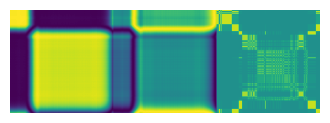

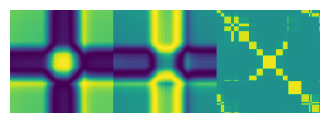

In [38]:
from fastai.vision.all import *
show_image(im1), show_image(im2)

In [39]:
#this is our y values
classes = classes.to_list()
Gun_NOgun = []
for o in classes:
    if o==1.0:
        Gun_NOgun.append('GUN')
    else: Gun_NOgun.append('NO_GUN')

In [40]:
# take all images and put them in directory based on class
path = Path("Images")
for i,o in enumerate(Gun_NOgun):
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    image = X_all[i]
    image = Image.fromarray(image, 'RGB')
    image.save(dest/f"{i}.jpg")
    # now at this moment b4 setting data loaders I manualy removed couple images frome each folder
    # so that it can used as unseen data to our model , but still preprocesed for model

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


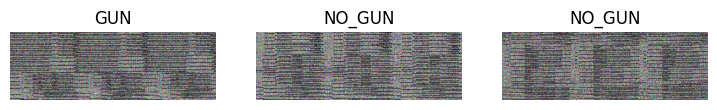

In [44]:
# set data loaders
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files,  
    splitter=RandomSplitter(valid_pct=0.2, seed=42), 
    get_y=parent_label, 
    item_tfms=None 
).dataloaders(path, bs=32)

dls.show_batch(max_n=3)

In [47]:
learn = vision_learner(dls, 'convnext_base', metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.396097,1.511747,0.410256,00:42


epoch,train_loss,valid_loss,error_rate,time
0,0.513026,0.671028,0.333333,02:14
1,0.465838,0.576926,0.307692,02:16
2,0.365305,0.553661,0.282051,02:08
3,0.297328,0.572802,0.230769,02:08
4,0.254372,0.595549,0.205128,02:08


In [51]:
# check predictions
categories = learn.dls.vocab
def predict(image):
    pred,idx,probs = learn.predict(image)
    return dict(zip(categories, map(float,probs)))


In [63]:
#one of images taken out b4 run it rought model 
path = Path('111NO_gun.jpg')
image = PILImage.create(path)

In [64]:
predict(image=image)

{'GUN': 0.11547426879405975, 'NO_GUN': 0.8845256567001343}

In [65]:
learn.export()

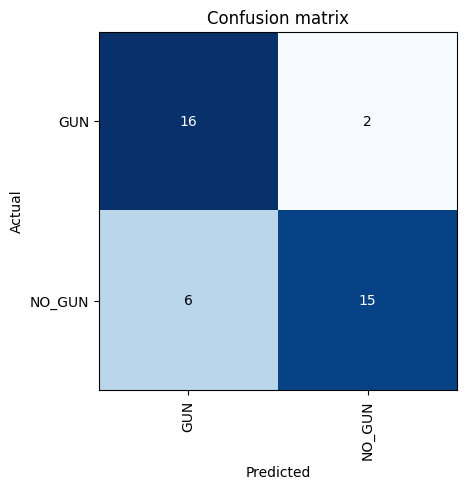

In [66]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()